In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.spatial import ConvexHull
import pandas as pd
from tensorflow import keras
from sklearn.manifold import TSNE
import os

In [2]:
data = np.load('kinase_data_splits.npz')

##### flattened test data => for vae

In [3]:
X_test = data['X_test']
print("Test shape:", X_test.shape)

Test shape: (2242, 5523)


##### reshaped flattened test data => for Tvae

In [4]:
sequence_length = 263
input_dim = 21

X_test_t = X_test.reshape(-1, sequence_length, input_dim)

## Loading models

### standard vae _ small

In [5]:
# --- Sampling Layer ---
class Sampling(layers.Layer):
    """
    Sampling layer that implements the reparameterization trick.
    Accepts [z_mean, z_log_var] and returns z = z_mean + exp(0.5*z_log_var)*epsilon.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super().get_config()
        return config

# --- Fully Connected VAE Model ---
class FullyConnectedVAE(Model):
    def __init__(self, input_dim=5523, latent_dim=32, **kwargs):
        """
        Parameters:
          input_dim (int): The size of the flattened input (e.g., 263*21 = 5523).
          latent_dim (int): The dimensionality of the latent space.
        """
        super(FullyConnectedVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # --- Encoder ---
        self.encoder_dense1 = layers.Dense(1024, activation='relu')
        self.encoder_dense2 = layers.Dense(512, activation='relu')
        self.encoder_dense3 = layers.Dense(256, activation='relu')
        self.z_mean_dense = layers.Dense(latent_dim)
        self.z_log_var_dense = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
        # --- Decoder ---
        self.decoder_dense1 = layers.Dense(256, activation='relu')
        self.decoder_dense2 = layers.Dense(512, activation='relu')
        self.decoder_dense3 = layers.Dense(1024, activation='relu')
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')
    
    def encode(self, inputs, training=False):
        """
        Encodes input data into the latent space.
        Returns: z_mean, z_log_var, z (sampled latent vector).
        """
        x = self.encoder_dense1(inputs)
        x = self.encoder_dense2(x)
        x = self.encoder_dense3(x)
        z_mean = self.z_mean_dense(x)
        z_log_var = self.z_log_var_dense(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z
    
    def decode(self, z, training=False):
        """
        Decodes a latent vector back into the original input space.
        Returns: a reconstructed vector of size input_dim.
        """
        x = self.decoder_dense1(z)
        x = self.decoder_dense2(x)
        x = self.decoder_dense3(x)
        reconstruction = self.decoder_output(x)
        return reconstruction
    
    def call(self, inputs, training=False):
        """
        Executes the model end-to-end, computing the reconstruction and adding the KL divergence loss.
        """
        z_mean, z_log_var, z = self.encode(inputs, training=training)
        reconstruction = self.decode(z, training=training)
        
        # Compute KL divergence: average over the batch.
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        
        return reconstruction
    
    def get_config(self):
        config = super(FullyConnectedVAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim
        })
        return config
# Rebuild the model architecture
vae = FullyConnectedVAE(input_dim=5523, latent_dim=32)
dummy_input = np.zeros((1, 5523), dtype=np.float32)  # Match input shape
_ = vae(dummy_input)  # Force layer creation

In [6]:
vae.load_weights('models/best_standard_vae_model.h5')  # Load weights

### Standard vae _ large trained on 200000 sequences

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sequence."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes a latent space point into a sequence."""
    
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.dense_output(x)

class VAE(Model):
    """Variational Autoencoder for protein sequences."""
    
    def __init__(self, original_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Scale KL loss by input dimension to balance it with reconstruction loss
        kl_loss = kl_loss * (1.0 / self.original_dim)
        
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return z_mean, z_log_var, z
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim
        })
        return config
    
# Rebuild the model architecture
vae_large = VAE(original_dim=5523, latent_dim=32)
dummy_input = np.zeros((1, 5523), dtype=np.float32)  # Match input shape
_ = vae_large(dummy_input)  # Force layer creation

In [15]:
vae_large.load_weights('models/200000seq_best_vae_model.h5')  # Load weights

### Transformer VAE v1 & v2

In [19]:
# ------ Custom Layers ------
class Sampling(layers.Layer):
    """Reparameterization trick layer"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super().get_config()

class PositionalEncoding(layers.Layer):
    """Positional encoding layer for transformer models."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        _, self.seq_length, self.d_model = input_shape
        super().build(input_shape)
    
    def get_angles(self, pos, i, d_model):
        # Ensure the base is a float: 10000.0 instead of 10000.
        angle_rates = 1 / tf.pow(tf.constant(10000.0, dtype=tf.float32), (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def call(self, x):
        # x shape: (batch, seq_length, d_model)
        # Create a tensor for positions: shape (seq_length, 1)
        positions = tf.cast(tf.range(self.seq_length)[:, tf.newaxis], tf.float32)
        # Create a tensor for the dimensions: shape (1, d_model)
        dims = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)
        angle_rads = self.get_angles(positions, dims, self.d_model)
        
        # Apply sin to even indices and cos to odd indices
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        
        # Concatenate along the last dimension. We need to interleave sin and cos.
        # One way is to create a tensor of the same shape as angle_rads and fill
        # even indices with sines and odd indices with cosines.
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[:, :self.d_model]  # Make sure the shape matches.
        pos_encoding = pos_encoding[tf.newaxis, ...]    # (1, seq_length, d_model)
        
        return x + pos_encoding

    def get_config(self):
        config = super().get_config()
        # Optionally include parameters like seq_length and d_model if needed.
        config.update({
            "seq_length": self.seq_length,
            "d_model": self.d_model,
        })
        return config

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, x, training=False):
        attn_output = self.mha(query=x, key=x, value=x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.mha.key_dim * self.mha.num_heads,
            # You could add more parameters here if needed.
        })
        return config

# ------ Custom Transformer Encoder/Decoder ------
class CustomTransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, seq_length, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.seq_length = seq_length
        self.pos_encoding = PositionalEncoding()
        self.enc_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, x, training=False):
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)
        for layer in self.enc_layers:
            x = layer(x, training=training)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'seq_length': self.seq_length
        })
        return config

class CustomTransformerDecoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, seq_length, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.seq_length = seq_length
        self.pos_encoding = PositionalEncoding()
        self.dec_layers = [TransformerBlock(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, x, training=False):
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)
        for layer in self.dec_layers:
            x = layer(x, training=training)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'seq_length': self.seq_length
        })
        return config

# ------ Transformer VAE Model ------
class TransformerVAE(Model):
    def __init__(self, seq_length=263, input_dim=21, latent_dim=32, num_heads=4, intermediate_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: Add positional encoding, then transformer encoder blocks.
        self.encoder_projection = layers.Dense(intermediate_dim)  # Project input_dim to intermediate_dim.
        self.transformer_encoder = CustomTransformerEncoder(num_layers=2, d_model=intermediate_dim, 
                                                             num_heads=num_heads, dff=intermediate_dim*2,
                                                             seq_length=seq_length, dropout_rate=0.1)
        self.pool = layers.GlobalAveragePooling1D()
        self.z_mean_dense = layers.Dense(latent_dim)
        self.z_log_var_dense = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
        # Decoder: Project latent back and reshape, followed by transformer decoder blocks.
        self.decoder_projection = layers.Dense(seq_length * intermediate_dim, activation='relu')
        self.decoder_reshape = layers.Reshape((seq_length, intermediate_dim))
        self.transformer_decoder = CustomTransformerDecoder(num_layers=2, d_model=intermediate_dim, 
                                                             num_heads=num_heads, dff=intermediate_dim*2,
                                                             seq_length=seq_length, dropout_rate=0.1)
        self.decoder_output = layers.Dense(input_dim, activation='softmax')
    
    def encode(self, inputs, training=False):
        # inputs shape: (batch, seq_length, input_dim)
        x = self.encoder_projection(inputs)    # (batch, seq_length, intermediate_dim)
        x = self.transformer_encoder(x, training=training)  # (batch, seq_length, intermediate_dim)
        x = self.pool(x)                       # (batch, intermediate_dim)
        z_mean = self.z_mean_dense(x)            # (batch, latent_dim)
        z_log_var = self.z_log_var_dense(x)      # (batch, latent_dim)
        return z_mean, z_log_var
    
    def decode(self, z, training=False):
        x = self.decoder_projection(z)          # (batch, seq_length * intermediate_dim)
        x = self.decoder_reshape(x)             # (batch, seq_length, intermediate_dim)
        x = self.transformer_decoder(x, training=training)  # (batch, seq_length, intermediate_dim)
        reconstruction = self.decoder_output(x) # (batch, seq_length, input_dim)
        return reconstruction
    
    def call(self, inputs, training=False):
        z_mean, z_log_var = self.encode(inputs, training=training)
        z = self.sampling([z_mean, z_log_var])
        reconstruction = self.decode(z, training=training)
        # Add KL divergence loss.
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        self.add_loss(kl_loss)
        return reconstruction
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "seq_length": self.seq_length,
            "input_dim": self.input_dim,
            "latent_dim": self.latent_dim,
        })
        return config

In [20]:
custom_objects = {
    'Sampling': Sampling,
    'PositionalEncoding': PositionalEncoding,
    'TransformerBlock': TransformerBlock,
    'CustomTransformerEncoder': CustomTransformerEncoder,
    'CustomTransformerDecoder': CustomTransformerDecoder,
    'TransformerVAE': TransformerVAE
}

# Load the model using the same file path as where you saved it
transformer_vae_v1 = load_model('models/best_transformer_vae_v1.keras', custom_objects=custom_objects)

transformer_vae_v1.summary()

Model: "transformer_vae_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (1, 263, 128)          │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_transformer_encoder      │ ?                      │       264,960 │
│ (CustomTransformerEncoder)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling_2 (Sampling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (1, 33664)             │     1,110,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (1, 263, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_transformer_decoder      │ ?                      │       264,960 │
│ (CustomTransformerDecoder)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (1, 263, 21)           │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963,841 (18.94 MB)

 Trainable params: 1,654,613 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,309,228 (12.62 MB)

In [28]:
custom_objects = {
    'Sampling': Sampling,
    'PositionalEncoding': PositionalEncoding,
    'TransformerBlock': TransformerBlock,
    'CustomTransformerEncoder': CustomTransformerEncoder,
    'CustomTransformerDecoder': CustomTransformerDecoder,
    'TransformerVAE': TransformerVAE
}

# Load the model using the same file path as where you saved it
transformer_vae_v2 = load_model('models/best_transformer_vae_v2.keras', custom_objects=custom_objects)

transformer_vae_v2.summary()

Model: "transformer_vae_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (1, 263, 128)          │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_transformer_encoder_1    │ ?                      │       264,960 │
│ (CustomTransformerEncoder)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling_3 (Sampling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (1, 33664)             │     1,110,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (1, 263, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_transformer_decoder_1    │ ?                      │       264,960 │
│ (CustomTransformerDecoder)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (1, 263, 21)           │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963,841 (18.94 MB)

 Trainable params: 1,654,613 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,309,228 (12.62 MB)

### Conv VAE small & large

In [31]:
# ------ Sampling Layer ------
class Sampling(layers.Layer):
    """Reparameterization trick layer."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super().get_config()

# ------ Convolutional VAE Model ------
class ConvVAE(Model):
    def __init__(self, sequence_length=263, input_dim=21, latent_dim=32, **kwargs):
        """
        Parameters:
          sequence_length: Number of amino acids per sequence (e.g., 263).
          input_dim: One-hot encoded dimension (e.g., 21).
          latent_dim: Dimension of the latent space (e.g., 32).
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # ------ Encoder ------
        # Input shape: (batch, 263, 21)
        self.conv1 = layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv2 = layers.Conv1D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv3 = layers.Conv1D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')
        self.flatten = layers.Flatten()
        
        # Compute the reduced sequence length using ceiling division.
        # After two conv layers with stride 2, reduced_seq_length = ceil(ceil(sequence_length/2)/2)
        self.reduced_seq_length = int(np.ceil(sequence_length / 2.0 / 2.0))  # For 263, expected to be 66.
        self.intermediate_dim = 128 * self.reduced_seq_length  # (128 * 66 = 8448)
        
        # Latent variable Dense layers.
        self.dense_z_mean = layers.Dense(latent_dim)
        self.dense_z_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        
        # ------ Decoder ------
        # Project latent vector back to flattened conv feature map.
        self.dense_decoder = layers.Dense(self.intermediate_dim, activation='relu')
        # Reshape to (reduced_seq_length, 128)
        self.reshape_decoder = layers.Reshape((self.reduced_seq_length, 128))
        
        # Upsampling and convolution to recover sequence length.
        self.upsample1 = layers.UpSampling1D(size=2)
        self.conv_dec1 = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.upsample2 = layers.UpSampling1D(size=2)
        self.conv_dec2 = layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')
        # Final reconstruction layer: output probabilities over 21 classes.
        self.conv_dec3 = layers.Conv1D(filters=input_dim, kernel_size=3, padding='same', activation='softmax')
        # Crop one extra time step if the output sequence length is 264 instead of 263.
        self.crop = layers.Cropping1D(cropping=(0, 1))
    
    def encode(self, inputs, training=False):
        # Encoder pathway.
        x = self.conv1(inputs)                  # (batch, 263, 32)
        x = self.conv2(x)                       # (batch, ~132, 64)
        x = self.conv3(x)                       # (batch, ~66, 128) – expect about 66 timesteps.
        x = self.flatten(x)                     # (batch, intermediate_dim)
        z_mean = self.dense_z_mean(x)
        z_log_var = self.dense_z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z
    
    def decode(self, z, training=False):
        x = self.dense_decoder(z)               # (batch, intermediate_dim)
        x = self.reshape_decoder(x)             # (batch, reduced_seq_length, 128)
        x = self.upsample1(x)                   # (batch, reduced_seq_length*2, 128)
        x = self.conv_dec1(x)                   # (batch, new_length, 64)
        x = self.upsample2(x)                   # (batch, reduced_seq_length*4, 64) -> likely 264 timesteps
        x = self.conv_dec2(x)                   # (batch, 264, 32)
        x = self.conv_dec3(x)                   # (batch, 264, 21)
        reconstruction = self.crop(x)           # Crop to (batch, 263, 21)
        return reconstruction
    
    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encode(inputs, training=training)
        reconstruction = self.decode(z, training=training)
        # Compute KL divergence loss.
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return reconstruction
    
    def get_config(self):
        config = super(ConvVAE, self).get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim
        })
        return config


In [32]:
# Create the custom_objects dictionary with all the custom objects used during training.
custom_objects = {
    'Sampling': Sampling,
    'ConvVAE': ConvVAE
}

# Load the model (saved in native Keras format, with .keras extension).
conv_vae_small = load_model('models/best_conv_vae.keras', custom_objects=custom_objects)

# Verify the loaded model:
conv_vae_small.summary()

Model: "conv_vae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (1, 263, 32)           │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (1, 132, 64)           │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (1, 66, 128)           │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 8448)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (1, 32)                │       270,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (1, 32)                │       270,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling_4 (Sampling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (1, 8448)              │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (1, 66, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (1, 132, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (1, 132, 64)           │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (1, 264, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (1, 264, 32)           │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (1, 264, 21)           │         2,037 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (1, 263, 21)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,656,001 (10.13 MB)

 Trainable params: 885,333 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,770,668 (6.75 MB)

In [33]:
# Create the custom_objects dictionary with all the custom objects used during training.
custom_objects = {
    'Sampling': Sampling,
    'ConvVAE': ConvVAE
}

# Load the model (saved in native Keras format, with .keras extension).
conv_vae_large = load_model('models/best_conv_vae_larg.keras', custom_objects=custom_objects)

# Verify the loaded model:
conv_vae_large.summary()

Model: "conv_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (1, 263, 32)           │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (1, 132, 64)           │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (1, 66, 128)           │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 8448)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (1, 32)                │       270,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (1, 32)                │       270,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling_5 (Sampling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (1, 8448)              │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (1, 66, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (1, 132, 128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (1, 132, 64)           │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (1, 264, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (1, 264, 32)           │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (1, 264, 21)           │         2,037 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_1 (Cropping1D)       │ (1, 263, 21)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,656,001 (10.13 MB)

 Trainable params: 885,333 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,770,668 (6.75 MB)

### Recurral vae

In [37]:
# --- Sampling Layer ---
class Sampling(layers.Layer):
    """Reparameterization trick layer."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super().get_config()

# --- Recurrent VAE Model ---
class RecurrentVAE(Model):
    def __init__(self, sequence_length=263, input_dim=21, latent_dim=32, lstm_units=128, **kwargs):
        """
        Parameters:
          sequence_length: Number of amino acids per sequence (e.g., 263)
          input_dim: Number of features per amino acid (e.g., 21 for one-hot encoding)
          latent_dim: Dimensionality of the latent space (e.g., 32)
          lstm_units: Number of units in the LSTM layers (e.g., 128)
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.lstm_units = lstm_units

        # ---- Encoder ----
        # LSTM encoder: returns the final hidden state only.
        self.encoder_lstm = layers.LSTM(lstm_units, return_state=True, return_sequences=False)
        self.z_mean_dense = layers.Dense(latent_dim)
        self.z_log_var_dense = layers.Dense(latent_dim)
        self.sampling = Sampling()

        # ---- Decoder ----
        # Repeat latent vector over the time dimension:
        self.repeat_vector = layers.RepeatVector(sequence_length)
        # LSTM decoder that returns sequences.
        self.decoder_lstm = layers.LSTM(lstm_units, return_sequences=True)
        # Dense output layer to get back probability distribution over 21 channels.
        self.output_dense = layers.TimeDistributed(layers.Dense(input_dim, activation='softmax'))

    def encode(self, inputs, training=False):
        # inputs shape: (batch, sequence_length, input_dim)
        # Run the LSTM; we ignore the cell state.
        _, state_h, _ = self.encoder_lstm(inputs)
        z_mean = self.z_mean_dense(state_h)
        z_log_var = self.z_log_var_dense(state_h)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def decode(self, z, training=False):
        # Repeat z over time steps to form a sequence.
        x = self.repeat_vector(z)  # shape: (batch, sequence_length, latent_dim)
        # Decode using LSTM.
        x = self.decoder_lstm(x)     # shape: (batch, sequence_length, lstm_units)
        reconstruction = self.output_dense(x)  # shape: (batch, sequence_length, input_dim)
        return reconstruction

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encode(inputs, training=training)
        reconstruction = self.decode(z, training=training)
        # Compute KL divergence loss.
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return reconstruction

    def get_config(self):
        config = super(RecurrentVAE, self).get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim,
            'lstm_units': self.lstm_units
        })
        return config

In [38]:
# Create the custom_objects dictionary with all the custom objects used during training.
custom_objects = {
    'Sampling': Sampling,
    'RecurrentVAE': RecurrentVAE
}

# Load the model (saved in native Keras format, with .keras extension).
rec_vae = load_model('models/best_recurrent_vae.keras', custom_objects=custom_objects)

# Verify the loaded model:
rec_vae.summary()

Model: "recurrent_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ((1, 128), (1, 128),   │        76,800 │
│                                 │ (1, 128))              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (1, 32)                │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sampling_6 (Sampling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (1, 263, 32)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, 263, 128)          │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (1, 263, 21)           │         2,709 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,593 (1.95 MB)

 Trainable params: 170,197 (664.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 340,396 (1.30 MB)

## MSE Evaluation

In [7]:
# Global data structure to store evaluation results from multiple models
evaluation_results = []  # Each entry will be a dict with keys: 'model_name', 'version', 'mse'

In [8]:
def evaluate_model_mse(model, X_test):
    """
    Evaluate a given model's reconstruction performance by computing the Mean Squared Error (MSE)
    between the original test data and the model's reconstruction.

    Parameters:
        model: a Keras model that outputs a reconstructed version of its input.
        X_test: numpy array of test data in the correct shape for this model
                (e.g., for a Transformer VAE: (batch, sequence_length, input_dim),
                 for a standard VAE that works on flattened data: (batch, 263*21))

    Returns:
        mse_value: a float, the MSE computed over the entire test set.
    """
    # Get reconstructed outputs from the model.
    predictions = model.predict(X_test)

    # Flatten both the original and the predictions to compute a single MSE value.
    X_test_flat = X_test.flatten()
    predictions_flat = predictions.flatten()

    mse_value = mean_squared_error(X_test_flat, predictions_flat)
    return mse_value

def store_evaluation_result(model_name, version, mse_value, results_data):
    """
    Append a new evaluation result to the results data structure.

    Parameters:
        model_name (str): Identifier for the model.
        version (str): Version of the model.
        mse_value (float): The computed MSE.
        results_data (list): The list to append the result.
    """
    results_data.append({
        'model_name': model_name,
        'version': version,
        'mse': mse_value
    })

def plot_evaluation_results(results_data):
    """
    Plot a bar chart comparing the MSE of different models stored in the results data structure.

    Parameters:
        results_data (list): List of dictionaries, each with keys 'model_name', 'version', 'mse'.
    """
    # Prepare lists for plotting.
    model_labels = [f"{res['model_name']} v{res['version']}" for res in results_data]
    mse_values = [res['mse'] for res in results_data]

    # Create the bar chart.
    plt.figure(figsize=(10, 6))
    plt.bar(model_labels, mse_values, color='skyblue')
    plt.xlabel("Model and Version")
    plt.ylabel("Reconstruction MSE")
    plt.title("Comparison of Reconstruction MSE Across Models")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


###### comparing

In [9]:
# STABDARD VAE MODEL:
mse_modelA = evaluate_model_mse(vae, X_test)
store_evaluation_result("Standard VAE", "small", mse_modelA, evaluation_results)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [16]:
# vae large
mse_model_vaelarg = evaluate_model_mse(vae_large, X_test)
store_evaluation_result("Standard VAE", "large", mse_model_vaelarg, evaluation_results)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [24]:
# TRANSFORMER VAE v1
mse_model_transformer_v1 = evaluate_model_mse(transformer_vae_v1, X_test_t)
store_evaluation_result("Transformer VAE", "1", mse_model_transformer_v1, evaluation_results)


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step


In [29]:
# TRANSFORMER VAE v2
mse_model_transformer_v2 = evaluate_model_mse(transformer_vae_v2, X_test_t)
store_evaluation_result("Transformer VAE", "2", mse_model_transformer_v2, evaluation_results)

71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step


In [34]:
# CONV VAE large and small
mse_model_conv_s = evaluate_model_mse(conv_vae_small, X_test_t)
store_evaluation_result("Conv VAE", "small", mse_model_conv_s, evaluation_results)

mse_model_conv_l = evaluate_model_mse(conv_vae_large, X_test_t)
store_evaluation_result("Conv VAE", "large", mse_model_conv_l, evaluation_results)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [39]:
# Rec VAE
mse_model_rec = evaluate_model_mse(rec_vae, X_test_t)
store_evaluation_result("Rec VAE", "1", mse_model_rec, evaluation_results)


71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step


In [40]:
evaluation_results

[{'model_name': 'Standard VAE',
  'version': 'small',
  'mse': 0.03603432700037956},
 {'model_name': 'Standard VAE',
  'version': 'large',
  'mse': 0.019772587344050407},
 {'model_name': 'Transformer VAE',
  'version': 'v1',
  'mse': 0.03606697544455528},
 {'model_name': 'Transformer VAE', 'version': '2', 'mse': 0.03605973720550537},
 {'model_name': 'Conv VAE', 'version': 'small', 'mse': 0.036083947867155075},
 {'model_name': 'Conv VAE', 'version': 'large', 'mse': 0.03600917011499405},
 {'model_name': 'Rec VAE', 'version': '1', 'mse': 0.04306528717279434}]

In [47]:
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_evaluation_results1(
    results_data,
    sort_by_mse=True,
    cmap_name='RdYlGn_r',
    decimal_places=2,
    use_log_scale=False,
    figsize=(10, 6),
    title="Comparison of Reconstruction MSE Across Models",
    xlabel="Model and Version",
    ylabel="Reconstruction MSE",
    annotate_bars=True,
    grid=True,
    **bar_kwargs
):
    """
    Plot an enhanced bar chart comparing the MSE of different models with optional annotations, sorting, and color mapping.

    Parameters:
        results_data (list): List of dictionaries, each with keys 'model_name', 'version', 'mse'.
        sort_by_mse (bool): Whether to sort models by MSE in ascending order. Defaults to True.
        cmap_name (str): Name of the colormap for coloring bars based on MSE. Defaults to 'RdYlGn_r'.
        decimal_places (int): Number of decimal places for MSE annotations. Defaults to 2.
        use_log_scale (bool): Whether to use a logarithmic scale for the y-axis. Defaults to False.
        figsize (tuple): Figure size as (width, height). Defaults to (10, 6).
        title (str): Title of the plot. Defaults to "Comparison of Reconstruction MSE Across Models".
        xlabel (str): Label for the x-axis. Defaults to "Model and Version".
        ylabel (str): Label for the y-axis. Defaults to "Reconstruction MSE".
        annotate_bars (bool): Whether to annotate bars with their MSE values. Defaults to True.
        grid (bool): Whether to display grid lines. Defaults to True.
        **bar_kwargs: Additional keyword arguments passed to plt.bar().

    Returns:
        fig (matplotlib.figure.Figure): The generated figure object.
        ax (matplotlib.axes.Axes): The axes object of the plot.
    """
    # Validate input data
    for res in results_data:
        if not all(key in res for key in ['model_name', 'version', 'mse']):
            raise ValueError("Each dictionary in results_data must contain 'model_name', 'version', and 'mse' keys.")
    
    # Sort results by MSE if required
    if sort_by_mse:
        results_data = sorted(results_data, key=lambda x: x['mse'])
    
    # Prepare data for plotting
    model_labels = [f"{res['model_name']} v{res['version']}" for res in results_data]
    mse_values = [res['mse'] for res in results_data]
    
    # Handle color mapping
    min_mse = min(mse_values) if mse_values else 0
    max_mse = max(mse_values) if mse_values else 0
    if max_mse == min_mse:
        norm_mse = [0.5] * len(mse_values)
    else:
        norm_mse = [(mse - min_mse) / (max_mse - min_mse) for mse in mse_values]
    cmap = cm.get_cmap(cmap_name)
    colors = cmap(norm_mse)
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot bars with colors
    bars = ax.bar(model_labels, mse_values, color=colors, **bar_kwargs)
    
    # Annotate bars with MSE values
    if annotate_bars:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.{decimal_places}f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8
            )
    
    # Set log scale if required
    if use_log_scale:
        if any(mse <= 0 for mse in mse_values):
            raise ValueError("All MSE values must be positive when using log scale.")
        ax.set_yscale('log')
    
    # Add grid lines
    if grid:
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Rotate x-tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Adjust layout
    fig.tight_layout()
    
    return fig, ax

##### Ploting

C:\Users\sajdv\AppData\Local\Temp\ipykernel_3464\2742239099.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Comparison of Reconstruction MSE Across Models'}, xlabel='Model and Version', ylabel='Reconstruction MSE'>)

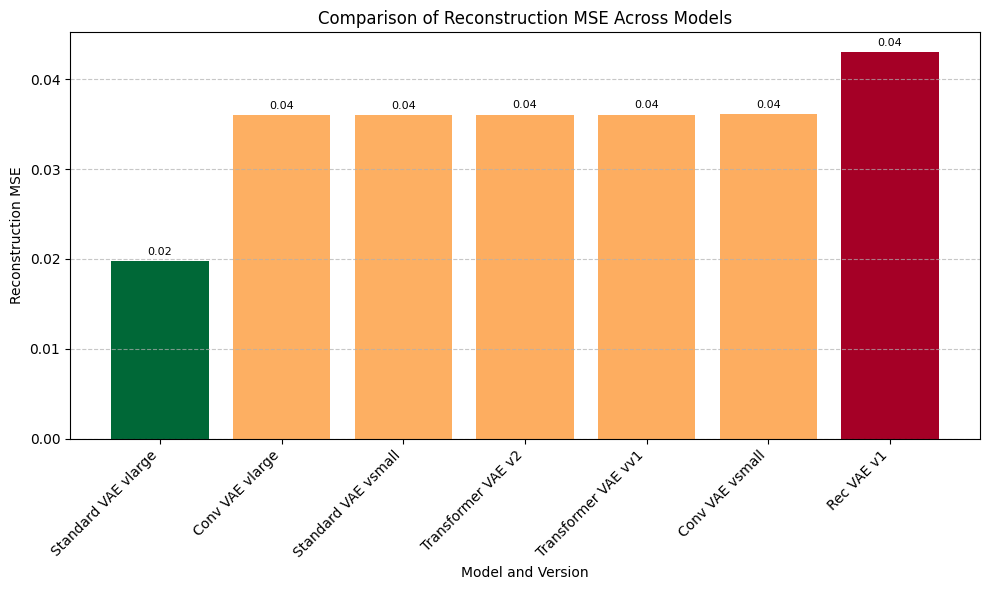

In [52]:
# Then, finally plot:
plot_evaluation_results1(evaluation_results)

## Cross Enthropy

In [53]:
# Global data structure to store evaluation results from multiple models
evaluation_results_bce = []  # Each entry: {'model_name': ..., 'version': ..., 'bce': ...}

In [54]:
def evaluate_model_bce(model, X_test):
    """
    Evaluate a given model's reconstruction performance by computing the 
    Binary Crossentropy (BCE) between the original test data and 
    the model's reconstruction.

    Parameters:
        model: a Keras model that outputs reconstructed input.
        X_test: numpy array of test data in the correct shape for the model.
                For Transformer VAE: shape (batch, sequence_length, input_dim)
                For standard VAE (flattened): shape (batch, 263*21)

    Returns:
        bce_value: A float representing the BCE computed over the test set.
    """
    bce_loss_fn = BinaryCrossentropy()
    # Generate reconstructions:
    predictions = model.predict(X_test)
    
    # Flatten both arrays
    X_test_flat = X_test.flatten()
    predictions_flat = predictions.flatten()
    
    # Compute BCE (BinaryCrossentropy loss function outputs a scalar per sample when appropriately reduced)
    bce_value = bce_loss_fn(X_test_flat, predictions_flat).numpy()
    return bce_value

def store_evaluation_result_bce(model_name, version, bce_value, results_data):
    """
    Append the model evaluation result (BCE) to the provided results list.

    Parameters:
        model_name (str): Model identifier.
        version (str): Model version.
        bce_value (float): Computed BCE value.
        results_data (list): Data structure (list) where results are stored.
    """
    results_data.append({
        'model_name': model_name,
        'version': version,
        'bce': bce_value
    })

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import StrMethodFormatter

def plot_evaluation_results_bce(
    results_data,
    sort_by_bce=True,
    cmap_name='RdYlGn_r',  # Red-Yellow-Green (reversed for better intuition)
    decimal_places=4,
    use_log_scale=False,
    figsize=(10, 6),
    title="Comparison of Reconstruction BCE Across Models",
    xlabel="Model and Version",
    ylabel="Binary Cross-Entropy (BCE)",
    annotate_bars=True,
    grid=True,
    bar_width=0.7,
    highlight_best=True,
    **bar_kwargs
):
    """
    Plot an enhanced bar chart comparing BCE scores across models with sorting, annotations, and color mapping.

    Parameters:
        results_data (list): List of dicts with keys 'model_name', 'version', 'bce'.
        sort_by_bce (bool): Sort models by BCE (ascending). Default: True.
        cmap_name (str): Colormap for bar colors. Default: 'RdYlGn_r'.
        decimal_places (int): Decimal precision for annotations. Default: 4.
        use_log_scale (bool): Use log scale for y-axis. Default: False.
        figsize (tuple): Figure size. Default: (10, 6).
        title (str): Plot title. Default: "Comparison of Reconstruction BCE Across Models".
        xlabel (str): X-axis label. Default: "Model and Version".
        ylabel (str): Y-axis label. Default: "Binary Cross-Entropy (BCE)".
        annotate_bars (bool): Annotate bars with BCE values. Default: True.
        grid (bool): Show grid lines. Default: True.
        bar_width (float): Width of bars. Default: 0.7.
        highlight_best (bool): Highlight the best (lowest BCE) model. Default: True.
        **bar_kwargs: Additional arguments for plt.bar().

    Returns:
        fig (matplotlib.figure.Figure): The figure object.
        ax (matplotlib.axes.Axes): The axes object.
    """
    # --- Input Validation ---
    for res in results_data:
        if not all(k in res for k in ['model_name', 'version', 'bce']):
            raise ValueError("Each entry must contain 'model_name', 'version', and 'bce' keys.")

    # --- Data Preparation ---
    if sort_by_bce:
        results_data = sorted(results_data, key=lambda x: x['bce'])

    labels = [f"{res['model_name']} v{res['version']}" for res in results_data]
    bce_values = np.array([res['bce'] for res in results_data])

    # --- Color Mapping ---
    norm = plt.Normalize(vmin=bce_values.min(), vmax=bce_values.max())
    cmap = cm.get_cmap(cmap_name)
    colors = cmap(norm(bce_values))

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(labels, bce_values, color=colors, width=bar_width, edgecolor='black', linewidth=0.5, **bar_kwargs)

    # --- Highlight Best Model ---
    if highlight_best and len(results_data) > 0:
        best_idx = np.argmin(bce_values)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(2)

    # --- Annotations ---
    if annotate_bars:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.{decimal_places}f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

    # --- Axis Formatting ---
    if use_log_scale:
        ax.set_yscale('log')
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.3f}"))  # Consistent decimal formatting
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, pad=20, fontweight='bold')

    # --- Grid & Aesthetics ---
    if grid:
        ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.tight_layout()

    return fig, ax

In [56]:
# STANDARD VAE:
bce_modelA1 = evaluate_model_bce(vae, X_test)
store_evaluation_result_bce("Standard VAE", "small", bce_modelA1, evaluation_results_bce)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [57]:
# STANDARD VAE large:
bce_modelA2 = evaluate_model_bce(vae_large, X_test)
store_evaluation_result_bce("Standard VAE", "large", bce_modelA2, evaluation_results_bce)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [58]:
# Transformer VAE v1
bce_model_transformer1 = evaluate_model_bce(transformer_vae_v1, X_test_t)
store_evaluation_result_bce("Transformer VAE", "1", bce_model_transformer1, evaluation_results_bce)

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step


In [59]:
# Transformer VAE v2
bce_model_transformer2 = evaluate_model_bce(transformer_vae_v2, X_test_t)
store_evaluation_result_bce("Transformer VAE", "2", bce_model_transformer2, evaluation_results_bce)

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step


In [60]:
# Conv VAE large and small
bce_model_conv1 = evaluate_model_bce(conv_vae_small, X_test_t)
store_evaluation_result_bce("Conv VAE", "small", bce_model_conv1, evaluation_results_bce)

bce_model_conv2 = evaluate_model_bce(conv_vae_large, X_test_t)
store_evaluation_result_bce("Conv VAE", "large", bce_model_conv2, evaluation_results_bce)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [61]:
# Rec
bce_model_rec = evaluate_model_bce(rec_vae, X_test_t)
store_evaluation_result_bce("Rec VAE", "v1", bce_model_rec, evaluation_results_bce)

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


C:\Users\sajdv\AppData\Local\Temp\ipykernel_3464\1532074035.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


[{'model_name': 'Standard VAE', 'version': 'small', 'bce': 0.13778202}, {'model_name': 'Standard VAE', 'version': 'large', 'bce': 0.075668626}, {'model_name': 'Transformer VAE', 'version': '1', 'bce': 0.1379382}, {'model_name': 'Transformer VAE', 'version': '2', 'bce': 0.1378839}, {'model_name': 'Conv VAE', 'version': 'small', 'bce': 0.1386862}, {'model_name': 'Conv VAE', 'version': 'large', 'bce': 0.13761699}, {'model_name': 'Rec VAE', 'version': 'v1', 'bce': 0.17374432}]


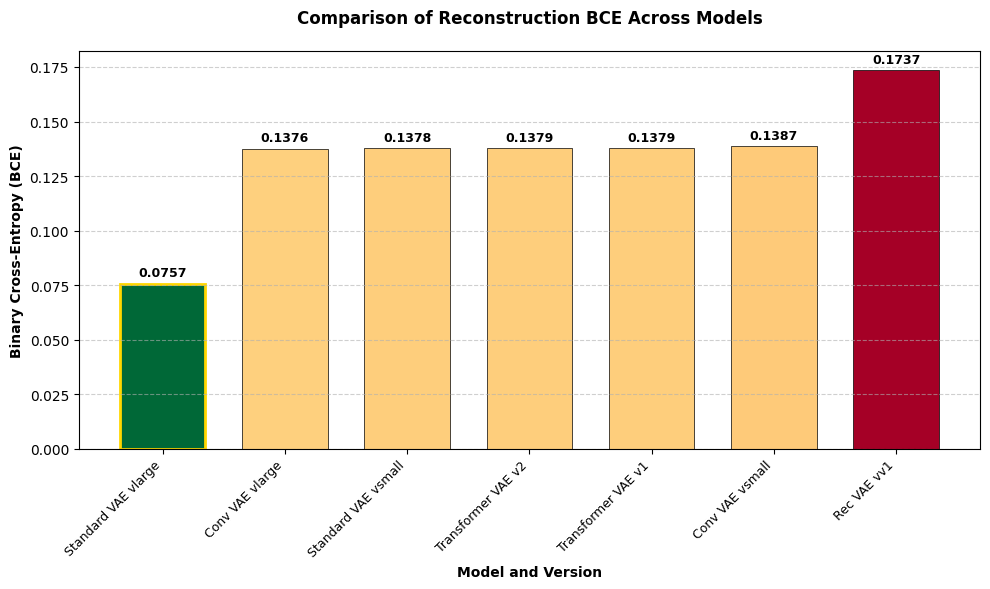

In [64]:
# Finally, plot:
plot_evaluation_results_bce(evaluation_results_bce)
print(evaluation_results_bce)

## Hamming Distance or Edit (Levenshtein) Distance on Decoded Sequences

In [150]:
# Define the amino acid alphabet (order must match the one-hot encoding)
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'

def one_hot_to_sequence(one_hot, alphabet=amino_acids):
    """
    Convert a one-hot encoded sequence or a probability distribution to a discrete amino acid sequence.
    
    Parameters:
        one_hot (np.array or tf.Tensor): Array of shape (sequence_length, feature_dim).
            Typically, feature_dim is len(alphabet) (here, 21).
        alphabet (str): The string of amino acids in order.
    
    Returns:
        seq (str): The decoded amino acid sequence.
    """
    # If tensor, convert to numpy array
    if hasattr(one_hot, 'numpy'):
        one_hot = one_hot.numpy()
    # Take argmax along the last dimension to get indices.
    indices = np.argmax(one_hot, axis=-1)
    # Map each index to its corresponding amino acid.
    seq = ''.join([alphabet[i] for i in indices])
    return seq

def hamming_distance(seq1, seq2):
    """
    Compute the Hamming distance between two sequences of equal length.
    
    Parameters:
        seq1 (str): Original sequence.
        seq2 (str): Reconstructed sequence.
    
    Returns:
        distance (int): Number of positions where the sequences differ.
    """
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must have the same length for Hamming distance.")
    return sum(ch1 != ch2 for ch1, ch2 in zip(seq1, seq2))



In [158]:
## USE FOR T VAE WITH X_TEST_T

def evaluate_hamming_distance(model, X_test, alphabet=amino_acids):
    """
    Evaluate a model by computing the average Hamming distance between the original sequences
    and the reconstructed sequences.
    
    Parameters:
        model: Trained Keras model that performs reconstruction.
        X_test (np.array): Test data. For Transformer VAE, expected shape (batch, sequence_length, input_dim).
        alphabet (str): Amino acid alphabet order.
        
    Returns:
        avg_hamming (float): Average Hamming distance over the test set.
        distances (list): List of Hamming distances for each sample.
    """
    # Get reconstructed outputs from the model using predict.
    predictions = model.predict(X_test)
    
    # Assuming the inputs X_test are in one-hot format, they are of shape (batch, sequence_length, input_dim)
    n_samples = X_test.shape[0]
    distances = []
    
    for i in range(n_samples):
        # Convert the original one-hot encoded sequence to string
        original_seq = one_hot_to_sequence(X_test[i], alphabet)
        # Convert the predicted probabilities sequence to string (argmax)
        reconstructed_seq = one_hot_to_sequence(predictions[i], alphabet)
        # Compute Hamming distance for this sample
        d = hamming_distance(original_seq, reconstructed_seq)
        distances.append(d)
    
    avg_hamming = np.mean(distances)
    return avg_hamming, distances

In [159]:
## USE WITH STANDARD VAE

def evaluate_hamming_distance_(model, X_test, alphabet=amino_acids):
    # Get predictions (shape: (batch, 5523))
    predictions = model.predict(X_test)
    
    # Reshape to (batch, 263, 21)
    X_test_3d = X_test.reshape(-1, 263, 21)          # Original data
    predictions_3d = predictions.reshape(-1, 263, 21)  # Reconstructions
    
    n_samples = X_test_3d.shape[0]
    distances = []
    
    for i in range(n_samples):
        original_seq = one_hot_to_sequence(X_test_3d[i], alphabet)
        reconstructed_seq = one_hot_to_sequence(predictions_3d[i], alphabet)
        d = hamming_distance(original_seq, reconstructed_seq)
        distances.append(d)
    
    avg_hamming = np.mean(distances)
    return avg_hamming, distances

In [154]:
# the DS
hamming_results = pd.DataFrame(columns=["model_name", "version", "avg_hamming", "distances"]) # for storing 

In [155]:
def evaluate_and_store_hamming(model, X_test, model_name, version="1.0", results_df=None):
    """
    Evaluate Hamming distance for a model and store results in a DataFrame.
    
    Parameters:
        model: Trained model.
        X_test: Test data (flattened one-hot encoded sequences).
        model_name (str): Name of the model (e.g., "StandardVAE").
        version (str): Model version (e.g., "1.0").
        results_df (pd.DataFrame): Existing results DataFrame to append to.
    
    Returns:
        results_df: Updated DataFrame with new results.
    """
    # Compute Hamming distances
    avg_hamming, distances = evaluate_hamming_distance(model, X_test)
    
    # Create new entry
    new_entry = pd.DataFrame([{
        "model_name": model_name,
        "version": version,
        "avg_hamming": avg_hamming,
        "distances": distances
    }])
    
    # Append to existing results
    if results_df is not None:
        results_df = pd.concat([results_df, new_entry], ignore_index=True)
    else:
        results_df = new_entry
    
    return results_df

In [156]:
# the DS
hamming_results = pd.DataFrame(columns=["model_name", "version", "avg_hamming", "distances"])

In [ ]:

# Evaluate multiple models
models_to_test = [
    ("Standard VAE", vae, "small"),
    ("Standard VAE", vae_large, "large")
]

hamming_results = None
for name, model, version in models_to_test:
    hamming_results = evaluate_and_store_hamming(
        model, X_test, name, version, hamming_results
    )


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
models_to_test = [
    ("Transformer VAE", transformer_vae_v1, "1"),
    ("Transformer VAE", transformer_vae_v2, "2"),
    ("Conv VAE", conv_vae_small, "small"),
    ("Conv VAE", conv_vae_large, "large"),
    ("Rec VAE", rec_vae, "1"),
]
for name, model, version in models_to_test:
    hamming_results = evaluate_and_store_hamming(
        model, X_test_t, name, version, hamming_results
    )

71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


In [161]:
hamming_results

,model_name,version,avg_hamming,distances
0,Standard VAE,small,166.392507,"[159, 151, 168, 161, 156, 181, 145, 170, 167, ..."
1,Standard VAE,large,81.840321,"[116, 20, 116, 24, 95, 6, 138, 101, 70, 12, 14..."
2,Transformer VAE,1,166.623550,"[156, 151, 168, 153, 157, 181, 148, 169, 167, ..."
3,Transformer VAE,2,166.443800,"[156, 147, 169, 158, 156, 184, 146, 168, 168, ..."
4,Conv VAE,small,166.632471,"[160, 148, 169, 158, 158, 179, 145, 165, 169, ..."
5,Conv VAE,large,166.360393,"[157, 147, 170, 161, 157, 184, 145, 166, 167, ..."
6,Rec VAE,1,212.389384,"[206, 218, 210, 207, 202, 212, 195, 216, 210, ..."


## Cosine Similarity or Correlation Measures

In [162]:
# Global data structure for storing cosine similarity evaluation results
evaluation_results_cosine = []  # Each entry: {'model_name': ..., 'version': ..., 'cosine_similarity': ...}

In [163]:
def evaluate_model_cosine_similarity(model, X_test):
    """
    Evaluate a given model's reconstruction performance by computing the average cosine similarity
    between the original test data and the model's reconstruction.
    
    Parameters:
        model: A Keras model that outputs reconstructed inputs.
        X_test: Numpy array of test data in the proper shape (e.g., for Transformer VAE: (batch, sequence_length, input_dim)).
        
    Returns:
        avg_cosine (float): The average cosine similarity across all test samples.
        similarities (list): A list of cosine similarity values for each test sample.
    """
    # Generate reconstructions using the model's predict function.
    predictions = model.predict(X_test)
    
    # Flatten each sample (i.e., reshape to (batch, -1))
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    predictions_flat = predictions.reshape(predictions.shape[0], -1)
    
    # Compute cosine similarity for each pair of original and prediction.
    # Here, cosine_similarity returns a matrix where [i,j] is the similarity between i-th sample of X_test_flat and j-th sample of predictions_flat.
    # We need to extract the diagonal to get pairwise similarities.
    sim_matrix = cosine_similarity(X_test_flat, predictions_flat)
    sample_similarities = np.diag(sim_matrix)
    
    # Compute the average cosine similarity across the test set.
    avg_cosine = np.mean(sample_similarities)
    return avg_cosine, sample_similarities

def store_evaluation_result_cosine(model_name, version, cosine_value, results_data):
    """
    Append a new cosine similarity evaluation result to the provided results list.
    
    Parameters:
        model_name (str): Identifier for the model.
        version (str): The model version.
        cosine_value (float): The computed average cosine similarity.
        results_data (list): The list to store the results.
    """
    results_data.append({
        'model_name': model_name,
        'version': version,
        'cosine_similarity': cosine_value
    })


In [167]:
def plot_evaluation_results_cosine(results_data, figsize=(12, 7), 
                                color_map='RdYlGn', add_stats=True,
                                sort_values=True, highlight_max=True):
    """
    Enhanced cosine similarity comparison plot with statistical annotations and visual improvements.
    
    Parameters:
        results_data (list/dict/df): Input data containing model performance. Can be:
            - List of dicts: [{'model_name':..., 'version':..., 'cosine_similarity':...}]
            - DataFrame: Columns should include model_name, version, cosine_similarity
        figsize (tuple): Figure dimensions (width, height)
        color_map (str): Matplotlib colormap for gradient coloring
        add_stats (bool): Whether to add statistical annotations
        sort_values (bool): Sort models by cosine similarity
        highlight_max (bool): Highlight the best-performing model
        
    Returns:
        fig, ax: Matplotlib figure and axes objects
    """
    import numpy as np
    import pandas as pd
    from matplotlib import cm
    from matplotlib.ticker import PercentFormatter
    
    # Convert input to consistent DataFrame format
    if isinstance(results_data, list):
        df = pd.DataFrame(results_data)
    elif isinstance(results_data, dict):
        df = pd.DataFrame([results_data])
    else:
        df = results_data.copy()
    
    # Create model-version labels
    df['model_label'] = df['model_name'] + ' v' + df['version'].astype(str)
    
    # Sort values if requested
    if sort_values:
        df = df.sort_values('cosine_similarity', ascending=False)
    
    # Setup plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create color gradient
    norm = plt.Normalize(vmin=df['cosine_similarity'].min()*0.95, 
                        vmax=df['cosine_similarity'].max()*1.05)
    cmap = cm.get_cmap(color_map)
    colors = cmap(norm(df['cosine_similarity']))
    
    # Plot bars
    bars = ax.bar(df['model_label'], df['cosine_similarity'], 
                 color=colors, edgecolor='black', linewidth=1, alpha=0.8)
    
    # Highlight max if requested
    if highlight_max and len(df) > 1:
        max_idx = df['cosine_similarity'].idxmax()
        bars[max_idx].set_edgecolor('gold')
        bars[max_idx].set_linewidth(3)
        bars[max_idx].set_hatch('//')
    
    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
    
    # Add statistical reference lines
    if add_stats:
        mean_val = df['cosine_similarity'].mean()
        median_val = df['cosine_similarity'].median()
        
        ax.axhline(mean_val, color='navy', linestyle='--', alpha=0.7)
        ax.axhline(median_val, color='purple', linestyle=':', alpha=0.7)
        
        ax.annotate(f'Mean: {mean_val:.3f}', 
                    xy=(0.98, mean_val), xycoords=('axes fraction', 'data'),
                    ha='right', va='center', color='navy',
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='navy', alpha=0.7))
        
        ax.annotate(f'Median: {median_val:.3f}', 
                    xy=(0.98, median_val), xycoords=('axes fraction', 'data'),
                    ha='right', va='center', color='purple',
                    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='purple', alpha=0.7))
    
    # Formatting
    ax.set_xlabel("Model and Version", fontweight='bold')
    ax.set_ylabel("Cosine Similarity", fontweight='bold')
    ax.set_title("Model Comparison by Cosine Similarity\n(Higher is Better)", 
                fontsize=14, pad=20, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # Format as percentages if values are 0-1
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label('Similarity Score', rotation=270, labelpad=15)
    
    plt.tight_layout()
    return fig, ax

In [165]:

# Evaluate multiple models
models_to_test = [
    ("Standard VAE", vae, "small"),
    ("Standard VAE", vae_large, "large")
]

for name, model, version in models_to_test:
    avg_cosine_A, sim_list_A = evaluate_model_cosine_similarity(model, X_test)
    store_evaluation_result_cosine(name, version, avg_cosine_A, evaluation_results_cosine)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
models_to_test = [
    ("Transformer VAE", transformer_vae_v1, "1"),
    ("Transformer VAE", transformer_vae_v2, "2"),
    ("Conv VAE", conv_vae_small, "small"),
    ("Conv VAE", conv_vae_large, "large"),
    ("Rec VAE", rec_vae, "1"),
]
for name, model, version in models_to_test:
    avg_cosine_A, sim_list_A = evaluate_model_cosine_similarity(model, X_test_t)
    store_evaluation_result_cosine(name, version, avg_cosine_A, evaluation_results_cosine)

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


C:\Users\sajdv\AppData\Local\Temp\ipykernel_3464\1103601137.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(color_map)


(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Model Comparison by Cosine Similarity\n(Higher is Better)'}, xlabel='Model and Version', ylabel='Cosine Similarity'>)

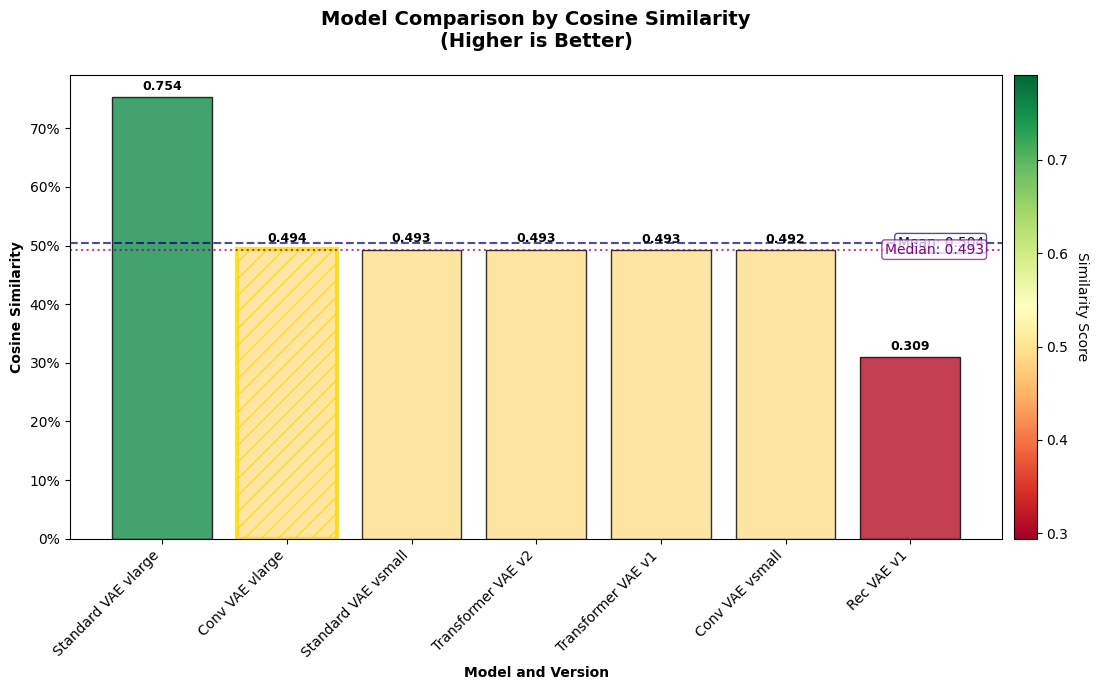

In [168]:
# Finally, plot the comparisons:
plot_evaluation_results_cosine(evaluation_results_cosine)

In [169]:
print(evaluation_results_cosine)

[{'model_name': 'Standard VAE', 'version': 'small', 'cosine_similarity': 0.49320576}, {'model_name': 'Standard VAE', 'version': 'large', 'cosine_similarity': 0.75352687}, {'model_name': 'Transformer VAE', 'version': '1', 'cosine_similarity': 0.4927596}, {'model_name': 'Transformer VAE', 'version': '2', 'cosine_similarity': 0.49300334}, {'model_name': 'Conv VAE', 'version': 'small', 'cosine_similarity': 0.49217808}, {'model_name': 'Conv VAE', 'version': 'large', 'cosine_similarity': 0.49376538}, {'model_name': 'Rec VAE', 'version': '1', 'cosine_similarity': 0.30947375}]


## Latent Space Evaluation (Indirect Reconstruction Quality)

In [170]:
def evaluate_latent_space(model, X_test, n_clusters=5, reduction_method='pca'):
    """
    Evaluate the latent space quality by computing latent representations 
    using model.encode(), clustering them, and computing the silhouette score.
    
    Parameters:
      model: A Keras model that implements .encode(X) returning (z_mean, z_log_var, z).
      X_test: Numpy array of test data in the correct shape (e.g., (-1, 263, 21) for Transformer VAE).
      n_clusters (int): Number of clusters for KMeans clustering.
      reduction_method (str): 'pca' to reduce latent space to 2D for visualization.
    
    Returns:
      sil_score (float): The silhouette score (higher is better, generally ranging from -1 to +1).
      latent_vectors (np.array): The full latent vectors computed from X_test.
      latent_proj (np.array): A 2D projection of the latent space (for visualization).
      cluster_labels (np.array): The labels assigned by KMeans.
    """
    # Compute latent representations using model.encode; we use the sampled latent z.
    z_mean, z_log_var, z = model.encode(X_test)
    latent_vectors = z.numpy() if hasattr(z, 'numpy') else z

    # Optionally reduce to 2D for visualization.
    if reduction_method == 'pca':
        pca = PCA(n_components=2)
        latent_proj = pca.fit_transform(latent_vectors)
    else:
        latent_proj = latent_vectors

    # Cluster the latent vectors with KMeans.
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)

    # Compute silhouette score on the full latent space.
    sil_score = silhouette_score(latent_vectors, cluster_labels)
    
    return sil_score, latent_vectors, latent_proj, cluster_labels

def plot_latent_projection(latent_proj, cluster_labels=None):
    """
    Plot the 2D projection of the latent space. If cluster_labels is provided,
    colors points accordingly.
    
    Parameters:
      latent_proj (np.array): The 2D projection of latent representations, shape (n_samples, 2).
      cluster_labels (np.array): Optional cluster labels for each sample.
    """
    plt.figure(figsize=(8, 6))
    if cluster_labels is not None:
        scatter = plt.scatter(latent_proj[:, 0], latent_proj[:, 1],
                              c=cluster_labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Cluster')
    else:
        plt.scatter(latent_proj[:, 0], latent_proj[:, 1], alpha=0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Latent Space Projection (PCA)")
    plt.show()

# Global container to store latent space evaluation metrics from multiple models.
evaluation_results_latent = []

def store_evaluation_result_latent(model_name, version, silhouette_value, results_data):
    """
    Stores the latent space evaluation result (silhouette score) for a given model.
    
    Parameters:
      model_name (str): A model identifier.
      version (str): Model version.
      silhouette_value (float): Computed silhouette score.
      results_data (list): Data structure (list) to store the results.
    """
    results_data.append({
        'model_name': model_name,
        'version': version,
        'silhouette': silhouette_value
    })

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Silhouette Score: 0.020718986


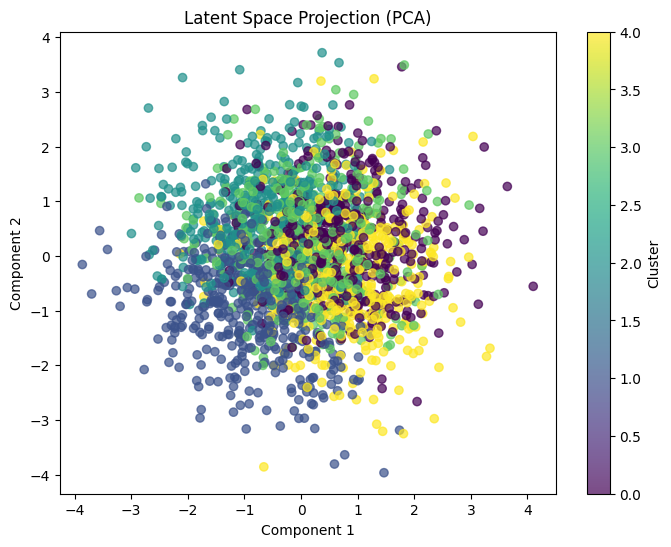

In [ ]:
# ===== Example Usage =====
# Assume X_test_t is your test set in the correct shape for your model.
# For Transformer VAE, it should have shape (-1, 263, 21).

# Evaluate latent space for a particular model.
sil_score, latent_vectors, latent_proj, cluster_labels = evaluate_latent_space(vae, X_test, n_clusters=5)
print("Silhouette Score:", sil_score)

# Store the result
store_evaluation_result_latent("TransformerVAE", "1.0", sil_score, evaluation_results_latent)

# Plot the 2D latent space projection.
plot_latent_projection(latent_proj, cluster_labels)

# You can then later compare multiple models by plotting the stored silhouette scores,
# for example, via a bar chart (similar to previous evaluation plots).

Silhouette Score: 0.019160612


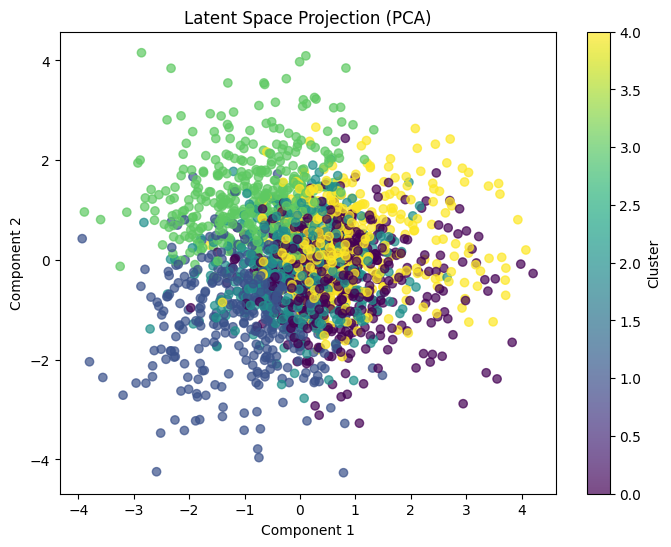

In [172]:
sil_score, latent_vectors, latent_proj, cluster_labels = evaluate_latent_space(vae_large, X_test, n_clusters=5)
print("Silhouette Score:", sil_score)

# Store the result
store_evaluation_result_latent("TransformerVAE", "1.0", sil_score, evaluation_results_latent)

# Plot the 2D latent space projection.
plot_latent_projection(latent_proj, cluster_labels)

Silhouette Score: 0.0225857


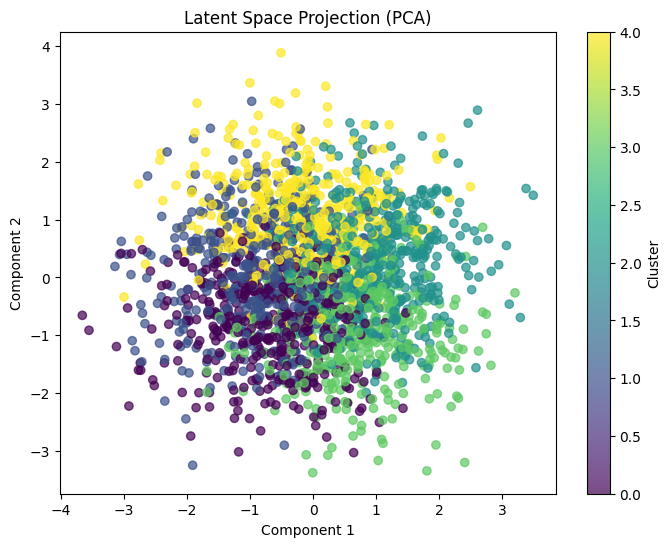

In [174]:
# FOR T VAE
sil_score, latent_vectors, latent_proj, cluster_labels = evaluate_latent_space(conv_vae_large, X_test_t, n_clusters=5,reduction_method='pca')
print("Silhouette Score:", sil_score)

# Store the result
store_evaluation_result_latent("TransformerVAE", "1.0", sil_score, evaluation_results_latent)

# Plot the 2D latent space projection.
plot_latent_projection(latent_proj, cluster_labels)

Silhouette Score: 0.02043327


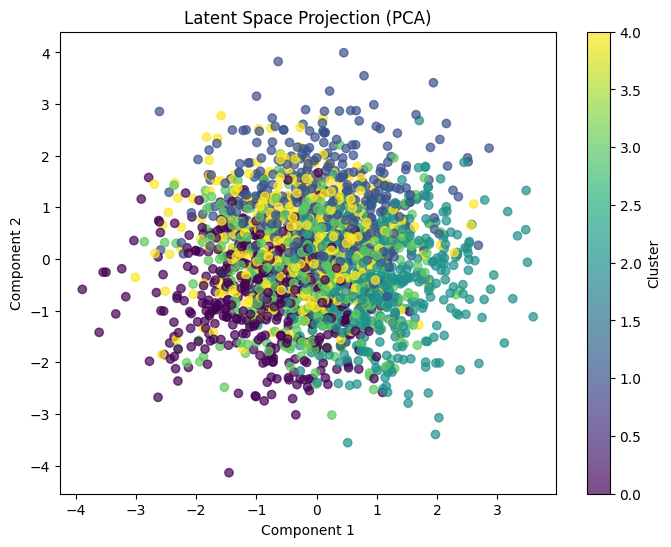

In [175]:
# FOR T VAE
sil_score, latent_vectors, latent_proj, cluster_labels = evaluate_latent_space(rec_vae, X_test_t, n_clusters=5,reduction_method='pca')
print("Silhouette Score:", sil_score)

# Store the result
store_evaluation_result_latent("TransformerVAE", "1.0", sil_score, evaluation_results_latent)

# Plot the 2D latent space projection.
plot_latent_projection(latent_proj, cluster_labels)

## Per-Position Accuracy

In [176]:
# Global data structure for storing per-position accuracy evaluation results.
evaluation_results_accuracy = []  # Each entry: {'model_name': ..., 'version': ..., 'accuracy': ...}

In [177]:
# This function is for Tvae

def evaluate_model_per_position_accuracy(model, X_test):
    """
    Evaluates the per-position accuracy between the original test data and the model's reconstruction.

    Parameters:
        model: A Keras model that reconstructs input sequences. The model must output data
               of the same shape as the input.
        X_test: Numpy array of test data with shape (batch, sequence_length, input_dim)
                For example, for Transformer VAE, shape might be (-1, 263, 21).

    Returns:
        overall_accuracy (float): The average per-position accuracy across all test samples.
        per_sample_accuracy (np.array): The per-sample accuracy (an array of shape (n_samples,)).
    """
    # Generate predictions (reconstructions) from the test data.
    predictions = model.predict(X_test)
    
    # For each position in the sequence, take the argmax to get the predicted class.
    # This assumes the output is a probability distribution over classes (one-hot style).
    original_classes = np.argmax(X_test, axis=-1)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    # Calculate accuracy per sample (i.e. percentage of positions correctly predicted)
    per_sample_accuracy = np.mean(original_classes == predicted_classes, axis=1)
    
    # Overall accuracy is then the average over all samples.
    overall_accuracy = np.mean(per_sample_accuracy)
    return overall_accuracy, per_sample_accuracy

def store_evaluation_result_accuracy(model_name, version, accuracy_value, results_data):
    """
    Stores the per-position accuracy result for a given model into the evaluation results data structure.

    Parameters:
        model_name (str): Identifier for the model.
        version (str): Model version.
        accuracy_value (float): Computed overall per-position accuracy.
        results_data (list): Data structure (list) where results are stored.
    """
    results_data.append({
        'model_name': model_name,
        'version': version,
        'accuracy': accuracy_value
    })

In [178]:
# for standard vae

def evaluate_model_per_position_accuracy(model, X_test):
    """
    Evaluates per-position accuracy for flattened one-hot inputs.
    """
    # Reshape flattened inputs to (batch, 263, 21)
    X_test_3d = X_test.reshape(-1, 263, 21)
    predictions = model.predict(X_test).reshape(-1, 263, 21)
    
    # Compute accuracy
    original_classes = np.argmax(X_test_3d, axis=-1)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    per_sample_accuracy = np.mean(original_classes == predicted_classes, axis=1)
    overall_accuracy = np.mean(per_sample_accuracy)
    return overall_accuracy, per_sample_accuracy

In [187]:
def plot_evaluation_results_accuracy(results_data, figsize=(12, 7), 
                                  color_map='RdYlGn', add_stats=True,
                                  sort_values=True, highlight_max=True,
                                  ylim=None, percentage_format=True):
    """
    Enhanced per-position accuracy comparison plot that actually displays data.
    
    Parameters:
        results_data: List of dicts or DataFrame containing:
            - model_name: str
            - version: str/number
            - accuracy: float (0-1)
            - [optional] accuracy_std: float
        figsize: Figure dimensions
        color_map: Colormap for gradient
        add_stats: Show mean/median lines
        sort_values: Sort by accuracy
        highlight_max: Highlight best model
        ylim: Tuple for y-axis limits
        percentage_format: Format as %
        
    Returns:
        fig, ax: Figure and axes objects
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import PercentFormatter

    # Convert to DataFrame if not already
    if not isinstance(results_data, pd.DataFrame):
        df = pd.DataFrame(results_data)
    else:
        df = results_data.copy()
    
    # Validate required columns
    required_cols = ['model_name', 'version', 'accuracy']
    if not all(col in df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df.columns]
        raise ValueError(f"Missing required columns: {missing}")

    # Create labels and sort
    df['model_label'] = df['model_name'] + ' v' + df['version'].astype(str)
    if sort_values:
        df = df.sort_values('accuracy', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize for color mapping
    accuracy_values = df['accuracy'].values
    norm = plt.Normalize(vmin=min(accuracy_values)*0.95, 
                        vmax=min(max(accuracy_values)*1.05, 1.0))
    cmap = cm.get_cmap(color_map)
    colors = cmap(norm(accuracy_values))
    
    # Plot bars with error bars if available
    has_std = 'accuracy_std' in df.columns
    yerr = df['accuracy_std'] if has_std else None
    
    bars = ax.bar(df['model_label'], df['accuracy'], 
                 color=colors, edgecolor='black', linewidth=1,
                 yerr=yerr, capsize=5, alpha=0.8)
    
    # Highlight best model
    if highlight_max and len(df) > 1:
        best_idx = df['accuracy'].idxmax()
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        bars[best_idx].set_hatch('//')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')
    
    # Add reference lines
    if add_stats:
        mean_val = df['accuracy'].mean()
        median_val = df['accuracy'].median()
        ax.axhline(mean_val, color='navy', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.3f}')
        ax.axhline(median_val, color='purple', linestyle=':', alpha=0.7, label=f'Median: {median_val:.3f}')
        ax.legend()
    
    # Format axes
    ax.set_xlabel("Model and Version", fontweight='bold')
    ax.set_ylabel("Accuracy", fontweight='bold')
    ax.set_title("Model Accuracy Comparison", fontsize=14, pad=20, fontweight='bold')
    
    if percentage_format:
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    if ylim:
        ax.set_ylim(ylim)
    else:
        buffer = 0.05 * (df['accuracy'].max() - df['accuracy'].min())
        ax.set_ylim(max(0, df['accuracy'].min() - buffer), 
                   min(1.0, df['accuracy'].max() + buffer))
    
    plt.xticks(rotation=45, ha='right')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label('Accuracy Score', rotation=270, labelpad=15)
    
    plt.tight_layout()
    return fig, ax

In [180]:
models_to_test = [
    ("Standard VAE", vae, "small", X_test),
    ("Standard VAE", vae_large, "large", X_test),
    ("Transformer VAE", transformer_vae_v1, "1", X_test_t),
    ("Transformer VAE", transformer_vae_v2, "2", X_test_t),
    ("Conv VAE", conv_vae_small, "small", X_test_t),
    ("Conv VAE", conv_vae_large, "large", X_test_t),
    ("Rec VAE", rec_vae, "1", X_test_t),
]
for name, model, version, test in models_to_test:
    # Evaluate per-position accuracy for a particular model.
    overall_acc, sample_accs = evaluate_model_per_position_accuracy(model, test)
    print("Overall Per-Position Accuracy on Test Set:", overall_acc)

    # Store the result.
    store_evaluation_result_accuracy(name, version, overall_acc, evaluation_results_accuracy)


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Overall Per-Position Accuracy on Test Set: 0.3674577627932692
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Overall Per-Position Accuracy on Test Set: 0.6891745216621499
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step
Overall Per-Position Accuracy on Test Set: 0.36649108108933154
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step
Overall Per-Position Accuracy on Test Set: 0.36677091000362927
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Overall Per-Position Accuracy on Test Set: 0.36624177896568444
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Overall Per-Position Accuracy on Test Set: 0.3674882895839198
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step
Overall Per-Position Accuracy on Test Set: 0.19264440019944168


C:\Users\sajdv\AppData\Local\Temp\ipykernel_3464\788457994.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(color_map)


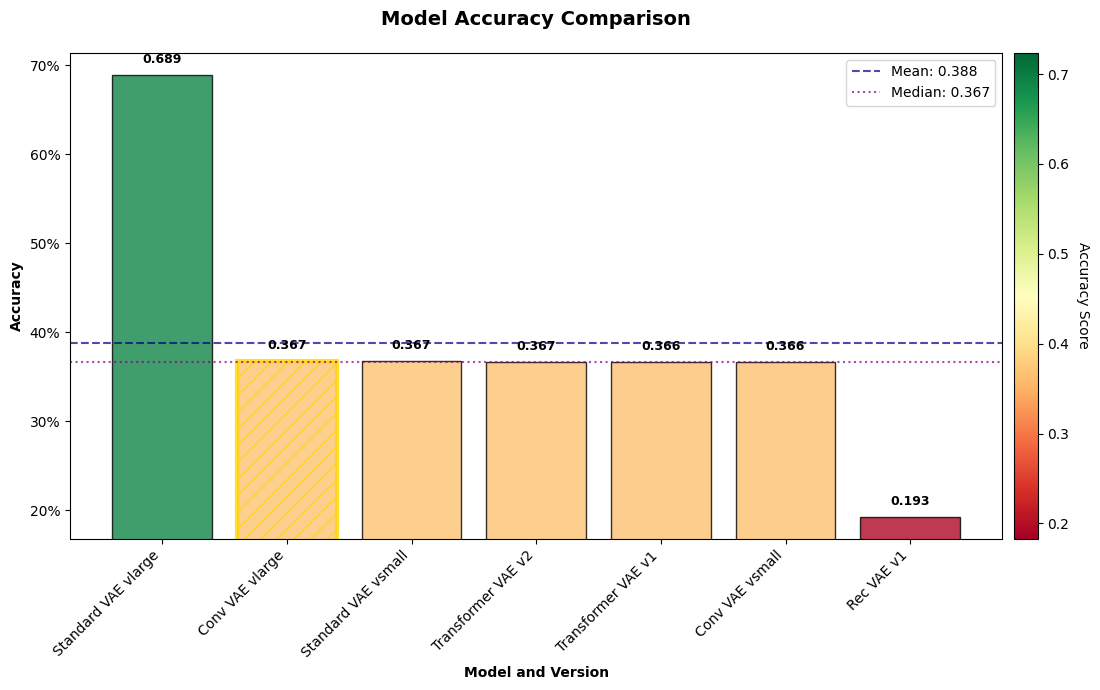

In [190]:
# Example usage with all options:
fig, ax = plot_evaluation_results_accuracy(evaluation_results_accuracy)
plt.show()

## generating new sequences

In [192]:
# Reshape flattened test data if necessary
if X_test.ndim == 2 and X_test.shape[1] == sequence_length * input_dim:
    X_test_seq = X_test.reshape(-1, sequence_length, input_dim)
else:
    X_test_seq = X_test

# Write to FASTA
fasta_path = 'test_sequences.fasta'
with open(fasta_path, 'w') as f:
    for i, seq_mat in enumerate(X_test_seq):
        # Convert one-hot encoding to sequence string
        indices = seq_mat.argmax(axis=1)
        seq = ''.join(amino_acids[idx] for idx in indices)
        f.write(f'>test_{i}\n{seq}\n')

print(f"Saved {X_test_seq.shape[0]} sequences to {fasta_path}")

Saved 2242 sequences to test_sequences.fasta


In [194]:
latent_dim = 32
zs = np.random.normal(size=(1000, latent_dim))

# 1) Decode → flat probabilities, shape (1000, 5523)
probs_flat = vae_large.decode(zs).numpy()

# 2) Reshape to (1000, 263, 21)
sequence_length = 263
input_dim = 21
probs = probs_flat.reshape(-1, sequence_length, input_dim)

# 3) Convert to discrete sequences
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
seqs = []
for p in probs:                  # p now has shape (263, 21)
    idxs = p.argmax(axis=-1)     # or axis=1
    seq = ''.join(amino_acids[i] for i in idxs)
    seqs.append(seq)

# 4) Write FASTA
with open('generated_kinases_vae_large.fasta','w') as f:
    for i, seq in enumerate(seqs):
        f.write(f'>gen_{i}\n{seq}\n')


In [195]:
latent_dim = 32
zs = np.random.normal(size=(1000, latent_dim))

# 1) Decode → flat probabilities, shape (1000, 5523)
probs_flat = vae_large.decode(zs).numpy()

# 2) Reshape to (1000, 263, 21)
sequence_length = 263
input_dim = 21
probs = probs_flat.reshape(-1, sequence_length, input_dim)

# 3) Convert to discrete sequences
amino_acids = 'XACDEFGHIKLMNPQRSTVWY'
seqs = []
for p in probs:                  # p now has shape (263, 21)
    idxs = p.argmax(axis=-1)     # or axis=1
    seq = ''.join(amino_acids[i] for i in idxs)
    seqs.append(seq)

# 4) Write FASTA
with open('generated_kinases_vae_large_masked.fasta','w') as f:
    for i, seq in enumerate(seqs):
        f.write(f'>gen_{i}\n{seq}\n')


In [ ]:
--FMKELGSGQFGEVQLGK-WRAQYPVAIKTLKEGTMSE---EDFIREAKVMKKLSHPKLVQLYGVCTQQEPIYIVTELMENGCLLNYLRERGHLSIDVLLDMCIQVCEGMAYLESNNFIHRDLAARNCLVNDNLVVKVADFGMARYVLDDEYYVSSKGAIKWCPPEALNYGRFSSKSDVWSFGVLMWEIFTGRMPYEGMSNYE-V--MLEQ----------GYRLYRPDLCPDEVYDLMLSCWKEKPEDRPTFKELCH----
>gen_9